## SERIE COLCAP (MODELO ARCH)
###  Oscar Layton

Los modelo ARCH o Heteroskedasticity condicional autoregresivo proporciona una manera de modelar un cambio en la varianza en una serie de tiempo que depende del tiempo, comúnmente es usado en series de tipo financiero en el cual se observa como aumentar o disminuir la volatilidad. No obstante va a servir específicamente para modelar la serie de retornos.

La serie de retornos de ${P_t}$

$$ r_t=log(P_t)-log(P_{t-1}) = log\frac{P_t}{P_{t-1}}$$

La serie de retornos es más fácil de manejar debido a que tiene propiedades de tipo estadístico que poseen llamadas hechos estilizados:

* Colas pesadas. La distribución no condicional de los retornos tienen colas mas pesadas que la distribución normal.
* Los retornos en general no presentan autocorrelación serial a menos que sean de alta frecuenci (No autocorrelación serial). 
* La distribución no condicional es sesgada de forma negativa (Asimetría).
* Padece de clúster de datos extremos, un retorno grande tiende a que se produzca un retorno grande.
* Las autocorrelaciones para potencias de la serie de retornos parecen significativas a diferencia de las autocorrealciones de la serie de retornos directamente.

A continuación se presenta la serie COLCAP:

In [14]:
import pandas           as pd
import matplotlib.pylab as plt
import scipy            as sp
import pmdarima         as pm
import numpy            as np
import math             as math

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools     import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools     import pacf

from statsmodels.tsa.arima_model   import ARIMA
from arch                          import arch_model
from matplotlib.pylab              import rcParams

In [17]:
produccion=pd.ExcelFile('C:/Users/YULY/Desktop/UNAL 2018/series de tiempo/codigos/Colcap.xlsx')
print(produccion.sheet_names)
produccion=produccion.parse('Colcap')

rgn=produccion["Fecha"]
serie=pd.Series(produccion['ValorCOLCAP'].values,index=rgn)
serie.head(10)

['ACC e ISE', 'Colcap']


Fecha
2008-01-15    980.2140
2008-01-16    958.9932
2008-01-17    928.3796
2008-01-18    903.4850
2008-01-21    832.3668
2008-01-22    879.6671
2008-01-23    890.8945
2008-01-24    933.7860
2008-01-25    939.6051
2008-01-28    930.9722
dtype: float64

En consecuencia la gráfica de la serie de tiempo está dada por:

Text(0.5, 1.0, 'Indice colcap')

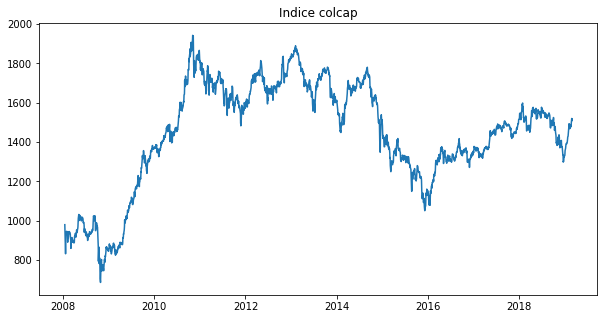

In [18]:
rcParams['figure.figsize'] = 10, 5
plt.plot(serie)
plt.title('Indice colcap')

### SERIE DE RETORNOS 
 
La serie de retornos de la serie Colcap se muestra acontinuación, cabe decir que se observan puntos cluster de valores extremos al principio de la serie, uno de los hechos estilizados para series financieras.

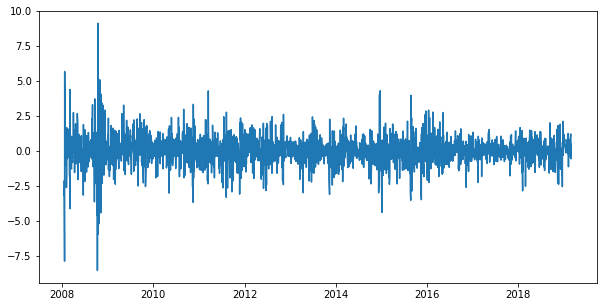

In [19]:
returns = 100 * serie.pct_change().dropna() 
plt.plot(returns) 

Una forma de identificar los demás hechos estilizados es por medio de la FAC y PACF las cuales se muestran a continuación:

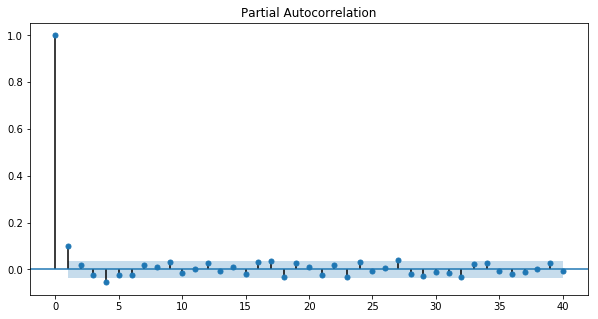

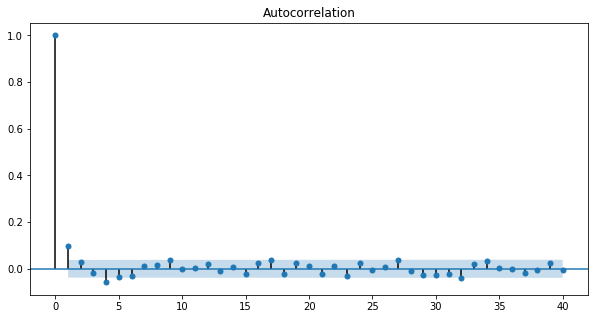

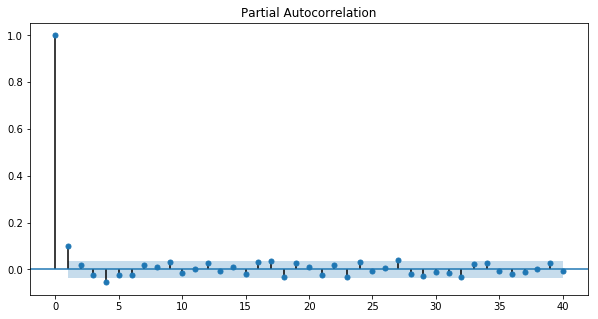

In [22]:
acf(returns,nlags=40,unbiased=False)
plot_acf(returns, lags=40, unbiased=False)

from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
pacf(returns,nlags=40)
plot_pacf(returns,lags=40)

Dadas las anteriores FAC y PACF, se puede identificar que:

* En ACF preácticamente ningún rezago es significativo, excepto por unos pocos
* Similarmente al caso anterior, en el PACF se observan pocos rezagos significativos.

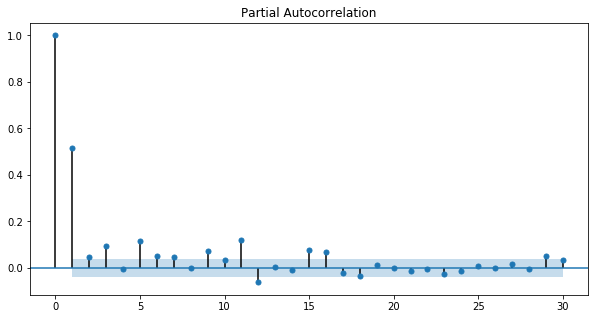

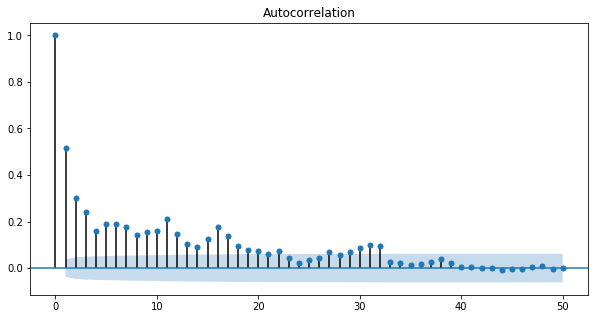

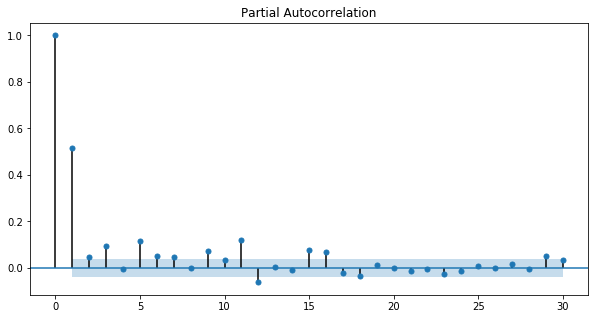

In [23]:
acf(returns**2,nlags=50,unbiased=False)
plot_acf(returns**2, lags=50, unbiased=False)  #$UN HECHO ESTILIZADO,, AL ELEVAR AL CUADRADO SE VE UNA AUTOCORRELACIOIN
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
pacf(returns**2,nlags=30)
plot_pacf(returns**2,lags=30)

En lo que compete a la FAC de la serie retornos al cuadrado, se ve autocorrelación , en el PACF de estos retornos al cuadrado resulta mucho más significativa que el ACF de la serie retornos original. En consecuencia se cumple otro hecho estilizado. Para afirmar el hecho se procede a realizar la prueba de multiplicadores de Lagrange para identificar este hecho:

In [24]:
 import statsmodels.api
 from statsmodels.stats.diagnostic  import het_arch  #pvalor es la segunda entrada
 statsmodels.stats.diagnostic.het_arch(returns**2)

(1267.203955013558, 2.940902999013245e-249, 84.78183234811253, 0.0)

La prueba es significativa, esto implica la presencia de volatilidad no constante a lo largo del tiempo

## Estimación y estimación del modelo

El modelo general que se tendra en cuenta para la serie de retornos es:

$$r_t = \mu_t + a_t$$  

* Donde la componente $\mu_t$ hará refererencia al valor esperado de $r_t$ dada la información disponible en el tiempo $t_1$: $E[r_t |T_{t-1}]$
* La componente $a_t$ explicara la varianza condicional de $r_t$ dado  $t_1$, es comunmente conocido como la volatilidad: $Var[r_t |T_{t-1}]$
    
El modelo para la esperanza condicional va a estimarse mediante un ARMA(p,q), obsevando la serie de retornos directamente en su estructura de correlacion, a partir de los residuales de este modelo se modela la volatilidad o varianza condicional se modelara mediante un modelo GARCH  (basado en la serie $\{  \widehat{a}_t \}$).

No obstante la atención se centra si la serie presenta heteroasticidad condicional y esta se detecta mediante las pruebas de Ljung-Box y Multiplicadores de Lagrange.


Etimando un modelo ARMA para la esperanza condicional se tiene:

In [29]:
import statsmodels.api as smapi
ar_orden=[1,0,0,0] 
ma_orden=[1,0,1,0] 
modeloAR = smapi.tsa.statespace.SARIMAX(returns, trend='n', order=(ar_orden,0,ma_orden))  
resultsAR = modeloAR.fit()
print(resultsAR.summary())



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              Statespace Model Results                              
Dep. Variable:                            y   No. Observations:                 2713
Model:             SARIMAX((1,), 0, (1, 3))   Log Likelihood               -3910.725
Date:                      Wed, 10 Jul 2019   AIC                           7829.451
Time:                              15:38:07   BIC                           7853.074
Sample:                                   0   HQIC                          7837.992
                                     - 2713                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5723      0.118      4.857      0.000       0.341       0.803
ma.L1         -0.4880      0.121     -4.041      0.000      -0.725      -0.251
ma.L

In [31]:
resultsAR.bic
 

7853.074045219933

In [34]:
Considerando que el ARMA hallado anteriormente es el que tiene menor BIC de los posibles, se realiza el análisis de residuales siguiente

SyntaxError: invalid syntax (<ipython-input-34-2b1fc6eadef8>, line 1)

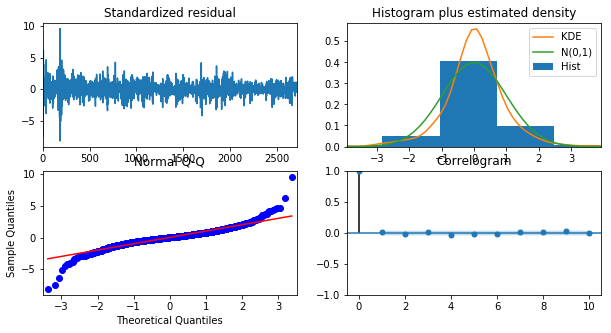

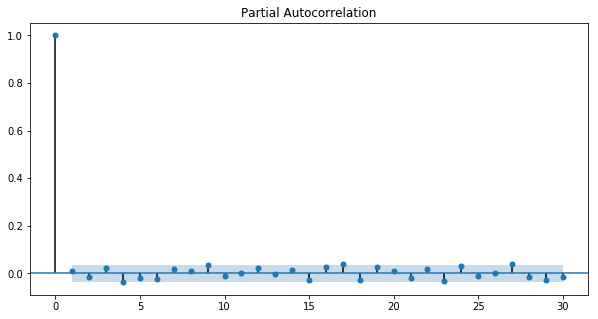

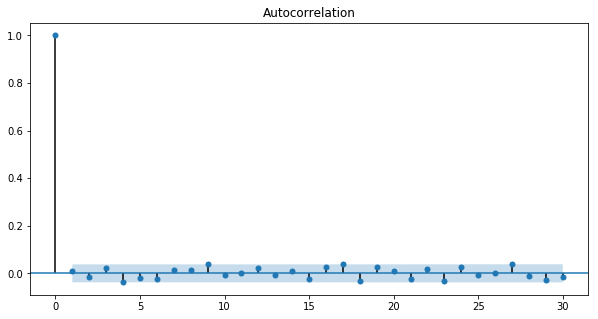

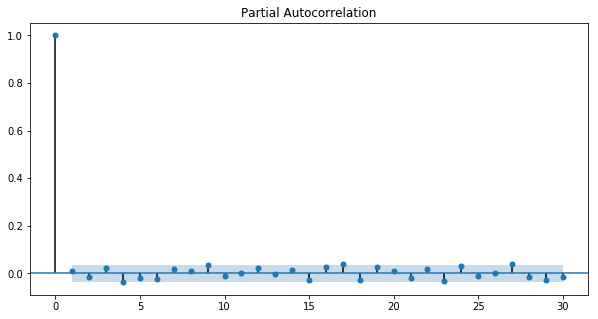

In [33]:

results=resultsAR
 
residuales=results.resid   
results.plot_diagnostics()
plt.show()

results.test_heteroskedasticity(method='breakvar')
results.test_normality(method='jarquebera')

acf(residuales,nlags=30,unbiased=False)
plot_acf(residuales,lags=30,unbiased=False)
pacf(residuales,nlags=30)
plot_pacf(residuales,lags=30)

Se obtiene un buen modelo para estimar la esperanza condicional que respeta los supuestos. Por consiguiente se procede a estimar la componente  $a_t$ para de esta manera identificar el modelo alusivo a la volatilidad:

Para identificar el modelo ARCH de la forma $a_t = \sigma_t \epsilon_t$ con $\epsilon_t \sim IID(0,\sigma^2)$ es importante identificar los parámetros $m, \alpha_0,\alpha_1,\alpha_2, ... , \alpha_m $ con $\alpha_0 >0$ , $\alpha_1,\alpha_2, ... , \alpha_m >= 0$, donde:

$$\sigma^2_t = \alpha_0 + \alpha_1 a^2_{t-1} + ...+\alpha_m a^2_{t-m}+ \beta_1 \sigma^2_{t-1} + \beta_2 \sigma^2_{t-2} + ... + \beta_l \sigma^2_{t-l}$$

Conociendo ACF Y PACF de la serie de retornos al cuadrado se identifican los ordenes GARCH

In [37]:
arch1 = arch_model(returns,p=4, o=0, q=4)
arch1_fit = arch1.fit()
print(arch1_fit.summary()) 

Iteration:      1,   Func. Count:     12,   Neg. LLF: 3557.57135955749
Iteration:      2,   Func. Count:     28,   Neg. LLF: 3556.891803020053
Iteration:      3,   Func. Count:     41,   Neg. LLF: 3527.4974563022633
Iteration:      4,   Func. Count:     54,   Neg. LLF: 3525.387864315453
Iteration:      5,   Func. Count:     68,   Neg. LLF: 3523.415235697133
Iteration:      6,   Func. Count:     82,   Neg. LLF: 3522.303230214731
Iteration:      7,   Func. Count:     96,   Neg. LLF: 3521.9783300024137
Iteration:      8,   Func. Count:    109,   Neg. LLF: 3520.236824611236
Iteration:      9,   Func. Count:    122,   Neg. LLF: 3519.6131276685555
Iteration:     10,   Func. Count:    135,   Neg. LLF: 3517.916972021906
Iteration:     11,   Func. Count:    148,   Neg. LLF: 3516.0676546807567
Iteration:     12,   Func. Count:    161,   Neg. LLF: 3515.980097280066
Iteration:     13,   Func. Count:    174,   Neg. LLF: 3515.7266167605358
Iteration:     14,   Func. Count:    186,   Neg. LLF: 3515.2

In [36]:
from arch import arch_model
am = arch_model(returns, mean='AR',  vol='harch', p=[1, 5, 22])
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     45,   Neg. LLF: 3531.601856104216
Iteration:     10,   Func. Count:     83,   Neg. LLF: 3522.784691270732
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3522.777845361341
            Iterations: 13
            Function evaluations: 104
            Gradient evaluations: 13
                           AR - HARCH Model Results                           
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      HARCH   Log-Likelihood:               -3522.78
Distribution:                  Normal   AIC:                           7055.56
Method:            Maximum Likelihood   BIC:                           7085.08
                                        No. Observations:                 2713
Date:                Wed, Jul 10 2019   Df Residuals:                     2708
Time:        

In [ ]:
## Pronosticos


In [38]:
from arch import arch_model
import datetime as dt
split_date = dt.datetime(2010,1,1)
res = am.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 782.4641524475155
Iteration:      2,   Func. Count:     18,   Neg. LLF: 778.8029061391758
Iteration:      3,   Func. Count:     28,   Neg. LLF: 778.0300206735243
Iteration:      4,   Func. Count:     36,   Neg. LLF: 776.8989051087473
Iteration:      5,   Func. Count:     44,   Neg. LLF: 775.7351324260235
Iteration:      6,   Func. Count:     52,   Neg. LLF: 775.6212851380018
Iteration:      7,   Func. Count:     60,   Neg. LLF: 775.5310759500744
Iteration:      8,   Func. Count:     67,   Neg. LLF: 775.4972211523103
Iteration:      9,   Func. Count:     74,   Neg. LLF: 775.4884142501949
Iteration:     10,   Func. Count:     81,   Neg. LLF: 775.4861289520111
Iteration:     11,   Func. Count:     88,   Neg. LLF: 775.4858283144654
Iteration:     12,   Func. Count:     95,   Neg. LLF: 775.4858253364091
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 775.4858253364353
            Iterations: 12
